In [1]:
import pickle
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import pairwise_distances

import os
os.chdir('../../')
from clustering_evaluation import ClusterPurity
evaluator=ClusterPurity()

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing:

### Load pre-trained RotatE Embedding Model on FB15k-237 Dataset:

In [3]:
PATH_Rotat_E = 'Dataset/rotatE_fb15k_128dim.pkl'

BASE_PATH_TRUTH = 'Dataset/Release'

In [4]:
# transe_fb15k-237.pkl: pre-trained model of fb15k with 1024 dim.
with open(PATH_Rotat_E, "rb") as fin:
    model = pickle.load(fin)
    
entity2id = model.graph.entity2id
relation2id = model.graph.relation2id

entity_embeddings = model.solver.entity_embeddings
relation_embeddings = model.solver.relation_embeddings

entity_embeddings.shape

(14951, 128)

### Extract ground-truth labels from FB15-237 dataset:

In [5]:
fb_train=pd.read_csv(BASE_PATH_TRUTH + '/train.txt', sep='\t', header=None, index_col=0)
fb_valid=pd.read_csv(BASE_PATH_TRUTH + '/valid.txt', sep='\t', header=None, index_col=0)
fb_test=pd.read_csv(BASE_PATH_TRUTH + '/test.txt', sep='\t', header=None, index_col=0)

fb_df=pd.concat([fb_train, fb_valid, fb_test])
fb_df['type']= fb_df[1].apply(lambda x: x.split('/')[1])

In [6]:
fb_df['type']

0
/m/027rn          location
/m/017dcd               tv
/m/07s9rl0    media_common
/m/01sl1q            award
/m/0cnk2q           soccer
                  ...     
/m/0l5yl            people
/m/01z5tr           people
/m/0p5mw             music
/m/0727h          military
/m/050r1z             film
Name: type, Length: 310116, dtype: object

### Get types of FB15k-237 entities:

In [7]:
ground_truth={}
for entity_id in entity2id.keys():
    if entity_id in fb_df.index:
        if isinstance(fb_df.loc[entity_id, 'type'], pd.core.series.Series): 
            ground_truth[entity_id]=fb_df.loc[entity_id, 'type'][0]
        else:
            ground_truth[entity_id]=fb_df.loc[entity_id, 'type']
    else:
        ground_truth[entity_id]='unknown' # for missed types

In [8]:
# count frequent types in ground_truth
from collections import Counter
Counter(ground_truth.values()).most_common()

[('award', 2552),
 ('people', 2184),
 ('film', 2158),
 ('location', 1472),
 ('unknown', 1060),
 ('music', 767),
 ('soccer', 693),
 ('common', 618),
 ('education', 617),
 ('base', 611),
 ('sports', 434),
 ('tv', 325),
 ('organization', 317),
 ('user', 161),
 ('business', 146),
 ('olympics', 137),
 ('government', 135),
 ('influence', 118),
 ('military', 67),
 ('media_common', 64),
 ('medicine', 55),
 ('language', 51),
 ('time', 43),
 ('travel', 42),
 ('dataworld', 28),
 ('ice_hockey', 28),
 ('food', 22),
 ('celebrities', 20),
 ('american_football', 18),
 ('baseball', 5),
 ('broadcast', 3)]

In [9]:
#filter top commen types
entity_embedding_filter=[]
y_true_filter=[]

top_types=['people', 'film', 'location', 'music', 'soccer', 'education']

for k, value in ground_truth.items():
    if value in top_types:        
        entity_embedding_filter.append(entity_embeddings[entity2id[k]])
        y_true_filter.append(value)

X_all = np.asarray(entity_embedding_filter)
X_all.shape        

(7891, 128)

### Encode the types as One-hot:

In [10]:
encoder = LabelEncoder()
y_all = encoder.fit_transform(y_true_filter)
labels = encoder.classes_.tolist()

## t-SNE Freebase visualization of FB15k-237 (RotatE Embedding)

In [11]:
X_2d = TSNE(random_state=42).fit_transform(X_all)

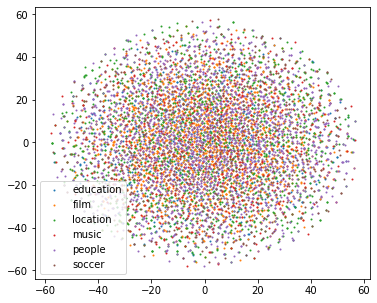

In [12]:
plt.figure(figsize=(6, 5))
label_ids = range(len(labels))
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[y_all == i, 0], X_2d[y_all == i, 1], c=c, label=label, s=1)

plt.legend() 
plt.savefig('./Experiments/FB15k-237/Figures/fb15k-rotatE-full.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()

# Unsupervisied Entity Typing:

## Method 1) HDBSCAN

In [13]:
import hdbscan

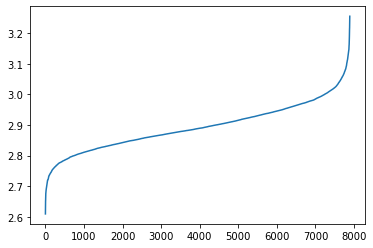

In [28]:
# final optimal value for cluster epsilon
neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(X_all)
distances, indices = nbrs.kneighbors(X_all)

distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)

In [14]:
%%time
X_all_double=X_all.astype(np.double)
hdbscan_clusterer=hdbscan.HDBSCAN(algorithm='best', alpha=0.1, metric='precomputed', cluster_selection_method='leaf',
                                      min_samples=10, min_cluster_size=700, core_dist_n_jobs=-1,allow_single_cluster=True,
                                      cluster_selection_epsilon=0.9)

distance_matrix = pairwise_distances(X_all_double, metric='cosine')
hdbscan_clusterer.fit(distance_matrix)

y_hdbscan=hdbscan_clusterer.labels_

# majority voting per cluster
df_tmp = pd.DataFrame({'pred_hdbscan': y_hdbscan, 'y_all': y_all})
pred_hdbscan = df_tmp.groupby('pred_hdbscan').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

CPU times: user 5.41 s, sys: 1.93 s, total: 7.33 s
Wall time: 4.22 s


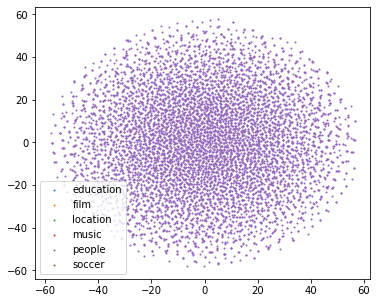

In [15]:
plt.figure(figsize=(6, 5))

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[pred_hdbscan == i, 0], X_2d[pred_hdbscan == i, 1], c=c, label=label, s=1)

plt.legend() 
plt.savefig('./Experiments/FB15k-237/Figures/fb15k-rotatE-hdbscan.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()

In [33]:
accuracy = accuracy_score(y_all, pred_hdbscan)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_hdbscan, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_hdbscan, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_hdbscan, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_hdbscan))

Accuracy: 0.276771
Precision: 0.076602
Recall: 0.276771
F1 score: 0.119994
Purity:  0.27677100494233936


## Method 2) K-means

In [16]:
%%time
kmeans = KMeans(n_clusters=len(top_types)).fit(X_all)
y_kmeans=kmeans.predict(X_all)

# majority voting per cluster
df_tmp = pd.DataFrame({'pred_kmeans': y_kmeans, 'y_all': y_all})
pred_kmeans = df_tmp.groupby('pred_kmeans').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

CPU times: user 19.1 s, sys: 1.58 s, total: 20.7 s
Wall time: 1.56 s


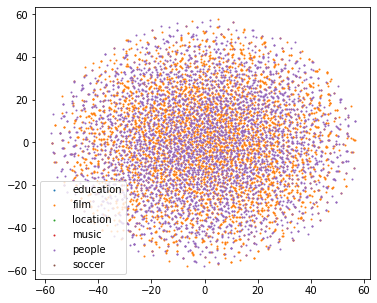

In [17]:
plt.figure(figsize=(6, 5))

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[pred_kmeans == i, 0], X_2d[pred_kmeans == i, 1], c=c, label=label, s=1)

plt.legend() 
plt.savefig('./Experiments/FB15k-237/Figures/fb15k-rotatE-Kmeans.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()

In [18]:
accuracy = accuracy_score(y_all, pred_kmeans)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_kmeans, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_kmeans, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_kmeans, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_kmeans))

Accuracy: 0.280953
Precision: 0.154625
Recall: 0.280953
F1 score: 0.199437
Purity:  0.28095298441262195


## Method 3) Agglomerative Clustering

In [19]:
%%time
aggClustering = AgglomerativeClustering(n_clusters=len(top_types)).fit(X_all)
y_aggClustering=aggClustering.fit_predict(X_all)

# majority voting per cluster
df_tmp = pd.DataFrame({'pred_agglom': y_aggClustering, 'y_all': y_all})
pred_agglom = df_tmp.groupby('pred_agglom').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

CPU times: user 9.25 s, sys: 439 ms, total: 9.69 s
Wall time: 9.69 s


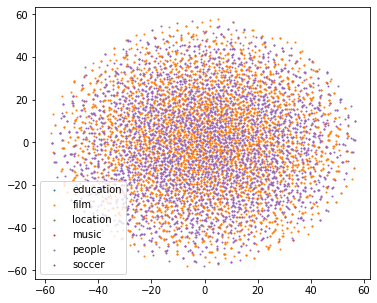

In [20]:
plt.figure(figsize=(6, 5))

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[pred_agglom == i, 0], X_2d[pred_agglom == i, 1], c=c, label=label, s=1)

plt.legend() 
plt.savefig('./Experiments/FB15k-237/Figures/fb15k-rotatE-agglom.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()

In [21]:
accuracy = accuracy_score(y_all, pred_agglom)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_agglom, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_agglom, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_agglom, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_agglom))

Accuracy: 0.284628
Precision: 0.156631
Recall: 0.284628
F1 score: 0.201934
Purity:  0.2846280572804461


# Supervised Baselines:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=42)

In [24]:
projection_train = TSNE(random_state=42).fit_transform(X_train)
projection_test = TSNE(random_state=42).fit_transform(X_test)

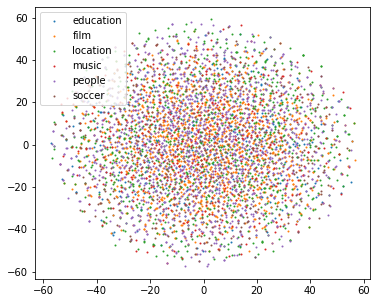

In [25]:
plt.figure(figsize=(6, 5))

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(projection_train[y_train == i, 0], projection_train[y_train == i, 1], c=c, label=label, s=1)

plt.legend() 
plt.savefig('./Experiments/FB15k-237/Figures/fb15k-rotatE-train.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()

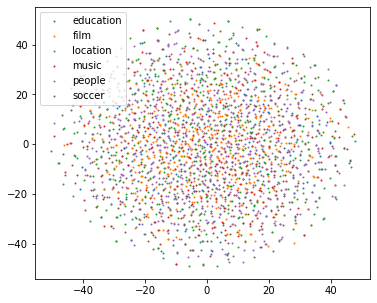

In [26]:
plt.figure(figsize=(6, 5))

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(projection_test[y_test == i, 0], projection_test[y_test == i, 1], c=c, label=label, s=1)

plt.legend() 
plt.savefig('./Experiments/FB15k-237/Figures/fb15k-rotatE-test.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()

## Method 1) Logistic Regression

In [27]:
%%time
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression(solver='liblinear',random_state=42).fit(X_train, y_train.ravel())
y_lr = logistic_clf.predict(X_test)

CPU times: user 227 ms, sys: 4.92 ms, total: 232 ms
Wall time: 210 ms


In [28]:

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_lr)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_lr, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_lr, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_lr, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_lr))

Accuracy: 0.266027
Precision: 0.217098
Recall: 0.266027
F1 score: 0.208668
Purity Score:  0.2836852207293666


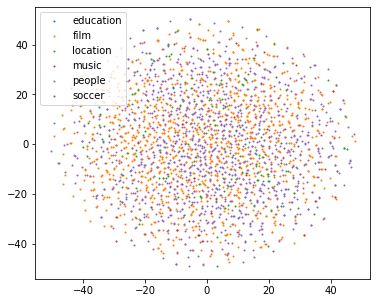

In [29]:
plt.figure(figsize=(6, 5))

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(projection_test[y_lr == i, 0], projection_test[y_lr == i, 1], c=c, label=label, s=1)

plt.legend() 
plt.savefig('./Experiments/FB15k-237/Figures/fb15k-rotatE-lr.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()

## Method 2) KNN

In [30]:
%%time
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train.ravel())
y_knn = neigh.predict(X_test)

CPU times: user 3.28 s, sys: 0 ns, total: 3.28 s
Wall time: 3.29 s


In [31]:

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_knn)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_knn, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_knn, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_knn, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_knn))

Accuracy: 0.232630
Precision: 0.182783
Recall: 0.232630
F1 score: 0.172651
Purity Score:  0.28253358925143957


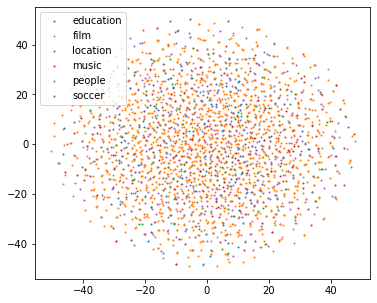

In [32]:
plt.figure(figsize=(6, 5))

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(projection_test[y_knn == i, 0], projection_test[y_knn == i, 1], c=c, label=label, s=1)

plt.legend() 
plt.savefig('./Experiments/FB15k-237/Figures/fb15k-rotatE-knn.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()

## Method 3) RandomForest

In [33]:
%%time
from sklearn.ensemble import RandomForestClassifier

random_clf = RandomForestClassifier(random_state=42).fit(X_train, y_train.ravel())
y_rf= random_clf.predict(X_test)

CPU times: user 10.6 s, sys: 0 ns, total: 10.6 s
Wall time: 10.6 s


In [34]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_rf)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_rf, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_rf, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_rf, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_rf))

Accuracy: 0.314779
Precision: 0.238152
Recall: 0.314779
F1 score: 0.253367
Purity Score:  0.31554702495201536


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


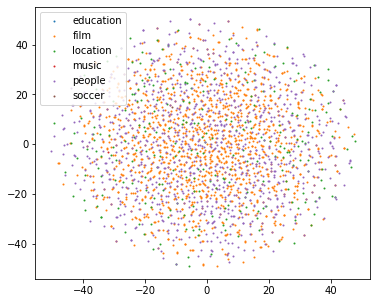

In [35]:
plt.figure(figsize=(6, 5))

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(projection_test[y_rf == i, 0], projection_test[y_rf == i, 1], c=c, label=label, s=1)

plt.legend() 
plt.savefig('./Experiments/FB15k-237/Figures/fb15k-rotatE-rf.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()

# Random Clustering Baselines:

## Method 1) Uniformly

In [36]:
# 6 Entity types from 0-5
y_random=np.random.choice([0, 1,2,3,4,5], size=y_all.shape[0])

In [37]:
# majority voting per cluster
df_tmp = pd.DataFrame({'y_random': y_random, 'y_all': y_all})
y_random = df_tmp.groupby('y_random').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

In [38]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_all, y_random)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, y_random, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, y_random, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, y_random, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=y_random))

Accuracy: 0.279306
Precision: 0.153693
Recall: 0.279306
F1 score: 0.198272
Purity:  0.27930553795463187


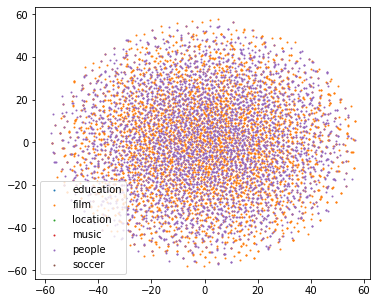

In [39]:
plt.figure(figsize=(6, 5))

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[y_random == i, 0], X_2d[y_random == i, 1], c=c, label=label, s=1)

plt.legend() 
plt.savefig('./Experiments/FB15k-237/Figures/fb15k-rotatE-random_uniformly.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()

## Method 2) By Class Distribution

In [40]:
weights=[]
y_counts=Counter(y_all)

for i in range(len(top_types)):
    weights.append(y_counts[i]/y_all.shape[0])
    
weights    

[0.07819034342922317,
 0.27347611202635913,
 0.1865416297047269,
 0.09719934102141681,
 0.27677100494233936,
 0.0878215688759346]

In [41]:
y_random_bala=np.random.choice([0,1,2,3,4,5], size=y_all.shape[0], p=weights)

# majority voting per cluster
df_tmp = pd.DataFrame({'y_random': y_random_bala, 'y_all': y_all})
y_random_bala = df_tmp.groupby('y_random').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

In [42]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_all, y_random_bala)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, y_random_bala, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, y_random_bala, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, y_random_bala, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=y_random_bala))

Accuracy: 0.281587
Precision: 0.155046
Recall: 0.281587
F1 score: 0.199456
Purity:  0.2815866176656951


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


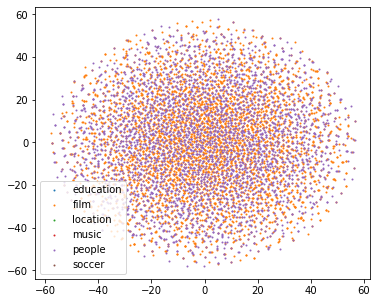

In [43]:
plt.figure(figsize=(6, 5))

for i, c, label in zip(label_ids, colors, labels):    
    plt.scatter(X_2d[y_random_bala == i, 0], X_2d[y_random_bala == i, 1], c=c, label=label, s=1)

plt.legend() 
plt.savefig('./Experiments/FB15k-237/Figures/fb15k-rotatE-random_classDist.png', dpi=600, bbox_inches='tight',pad_inches=0)
plt.show()